## Lesson 11:
### Exercise 1: The transient universe 

In [214]:
import emcee
import numpy as np
from matplotlib import pyplot as plt
import scipy as scipy
from scipy import stats
from tqdm.notebook import tqdm
import corner
import seaborn as sns
from astroML.stats import median_sigmaG
%config InlineBackend.figure_format='retina'
c = sns.color_palette('rocket', 5)

In [3]:
file = np.load('transient.npy')

In [4]:
time = file[:, 0]
flux = file[:, 1]
errors = file[:, 2]

In [ ]:
# Burst + exponential tail model definition
def burst_f (x, par): # par is a vector containing the 4 parameters characterizing the burst function
    b, A, t_0, alfa = par
    burst = b + A * np.exp(-alfa*(x-t_0))  
    return np.where(x < t_0, b, burst)

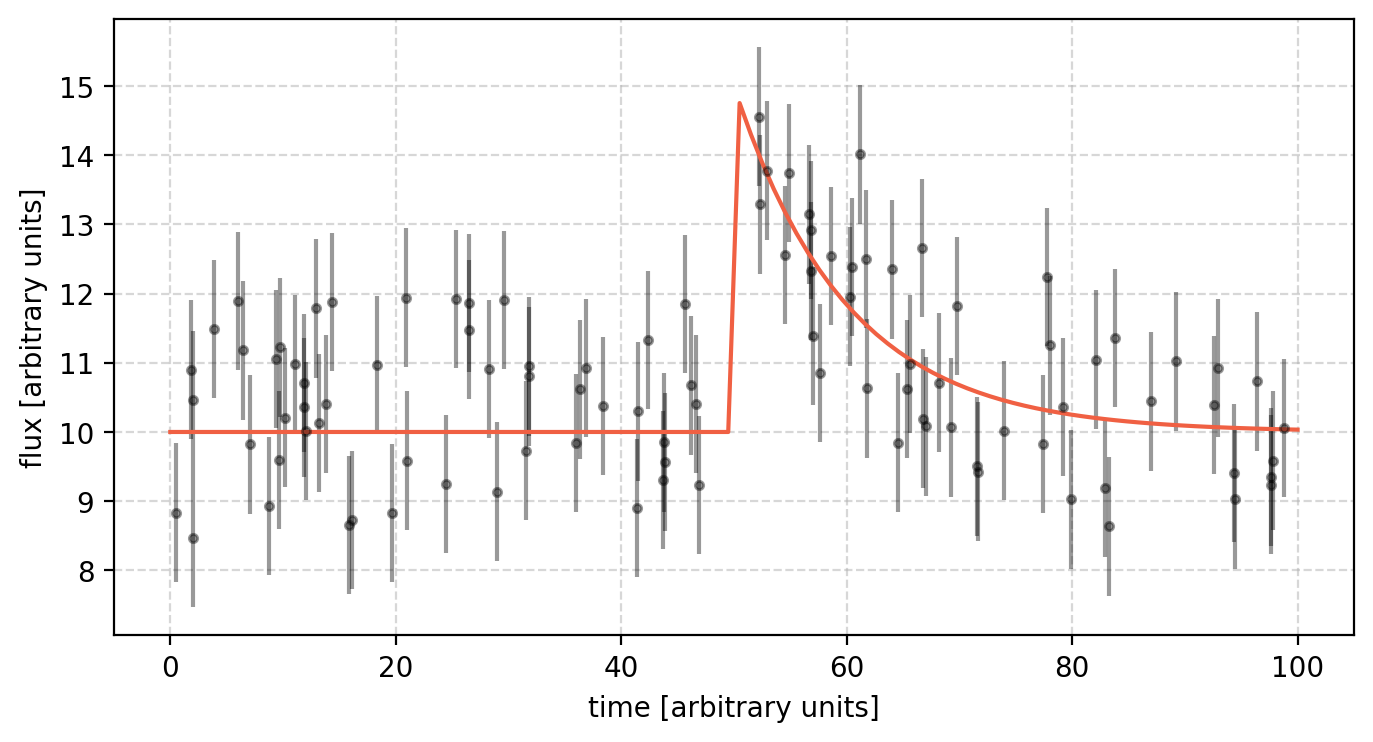

In [113]:
fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
xgrid = np.linspace(0, 100, 100)

par_guesses = (10, 5, 50, 0.1)

ax.set_xlabel('time [arbitrary units]')
ax.set_ylabel('flux [arbitrary units]')
ax.errorbar(time, flux, yerr=errors, fmt=".", c='black', alpha=0.4)
ax.plot(xgrid, burst_f(xgrid, par_guesses), color=c[3])

ax.grid(True, ls='--', alpha=0.5)

### Defining the likelihood, prior and posterior distributions

We can make the assumption of *gaussianly distributed* data, so that the likelihood can be computed as follows (As we saw in *Lecture 6*):

$$L = \prod_{i=1}^N p(t_i | y_i, M(t_i, \theta), \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \prod_{i=1}^N \exp\Big(-\frac{(y_i - M(t_i,\theta)^2}{2\sigma^2}\Big)$$

$$\ln{L} = const - \frac{1}{2}\sum_{i=1}^{N} \frac{(y_i - M(t_i,\theta)^2)}{2\sigma^2}$$

where:

$M(t, \theta) = M(t, b, A, t_0, \alpha) = $

>$b$, for $t<t_0$

>$b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

In [6]:
t = np.copy(time)
data = np.copy(flux)
sigma = np.copy(errors)

In [96]:
def LogLikelihood(par):
    model = burst_f(t, par)
    f = (1/sigma**2)*(data - burst_f(t, par))**2 
    return (-0.5)*np.sum(f) #Neglecting the const

def Prior(par):
    #uniform prior in (b, A, t_0, alpha)
    prior_b = stats.uniform.pdf(par[0], loc=0, scale=50)
    prior_A = stats.uniform.pdf(par[1], loc=0, scale=50)
    prior_t0 = stats.uniform.pdf(par[2], loc=0, scale=100)
    prior_alpha = stats.loguniform.pdf(par[3], np.exp(-5), np.exp(5))
    
    return  prior_b * prior_A * prior_t0 * prior_alpha

def LogPosterior(par):
    
    lprior =  np.log(Prior(par))
    if not np.isfinite(lprior):
        return -np.inf
    else:
        return LogLikelihood(par) + lprior

> `emcee` uses multiple walkers to explore the posterior distribution. We set an initial guess for the parameter (or parameters) for each of those walkers

In [141]:
nwalkers = 15
ndim = 4
burn = 400
nsteps = 10000

In [142]:
# We initialize the parameters
guesses = np.array([10, 5, 50, 0.1])
starting_guesses = guesses + np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(starting_guesses, nsteps, progress=True) 

print('done')

  0%|                                                 | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_27904/236826610.py:23: RuntimeWarning: divide by zero encountered in log
  lprior =  np.log(Prior(par))
100%|████████████████████████████████████| 10000/10000 [00:40<00:00, 247.75it/s]

done


### Trace-plots

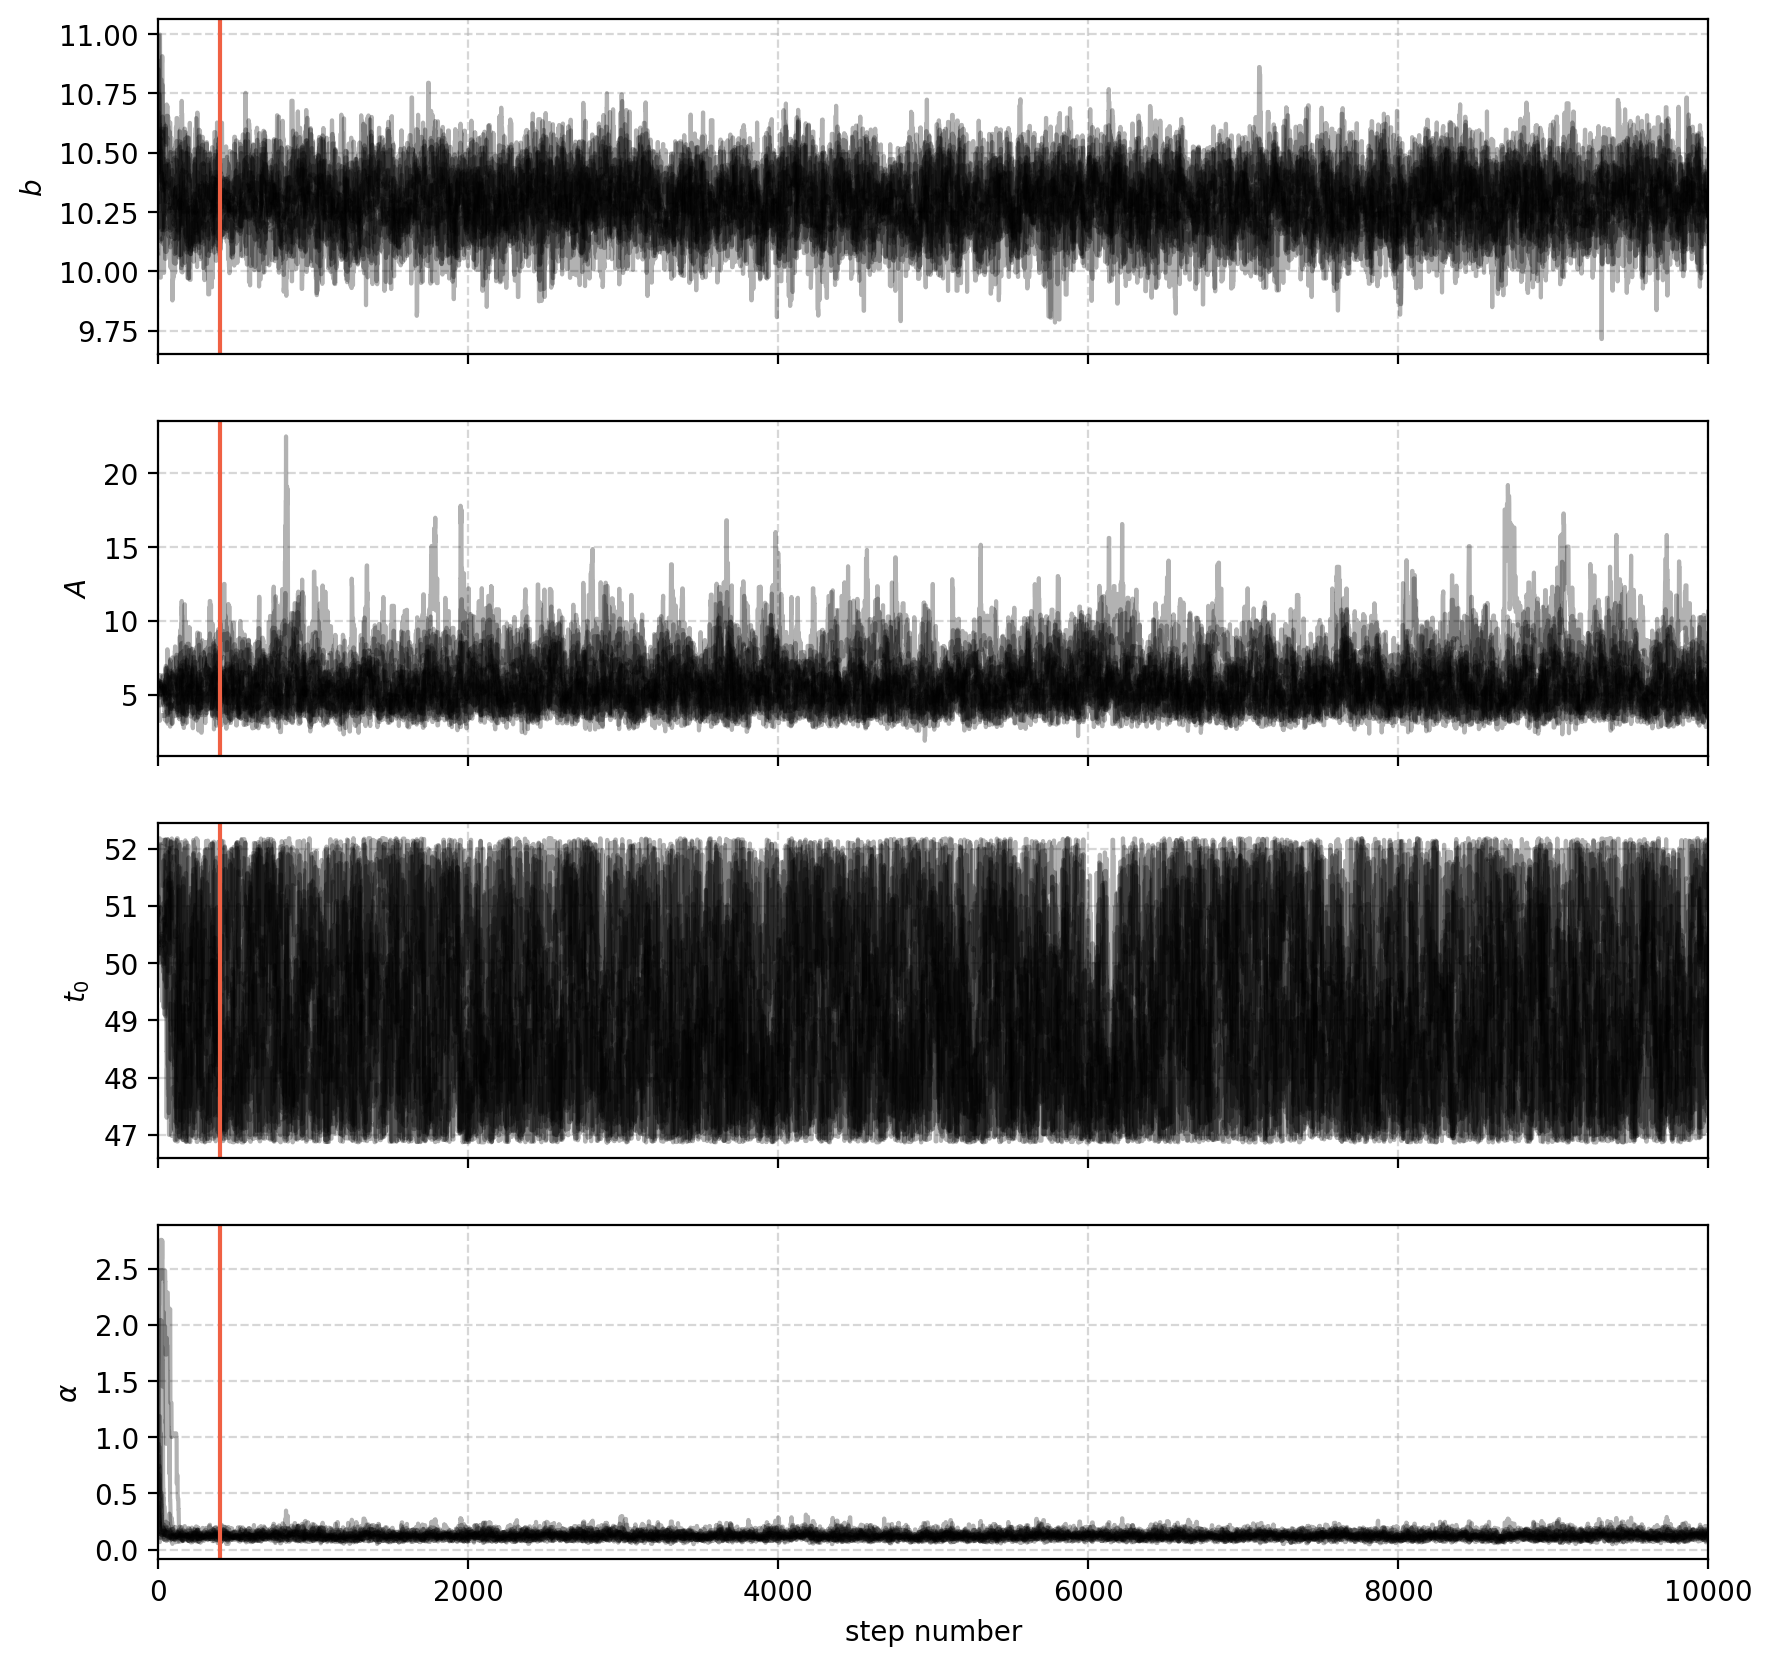

In [143]:
fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)
samples = sampler.get_chain() #not thinned nor "de-burned"

labels = [r"$b$",r"$A$", r"$t_0$", r"$\alpha$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i], 'k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.grid(True, ls='--', alpha=0.5)
    ax.axvline(burn, color=c[3])
    
axes[-1].set_xlabel("step number");

### Thinning

In [144]:
tau = sampler.get_autocorr_time()
print(tau)
thin_tau = int(np.mean(tau))
print(thin_tau)

[59.26272116 86.44026168 82.99862486 66.1089053 ]
73


In [145]:
samples = sampler.get_chain(discard=burn, thin=thin_tau, flat=False)
flat_samples = sampler.get_chain(discard=burn, thin=thin_tau, flat=True)
print(flat_samples.shape)

(1965, 4)


### Corner plot

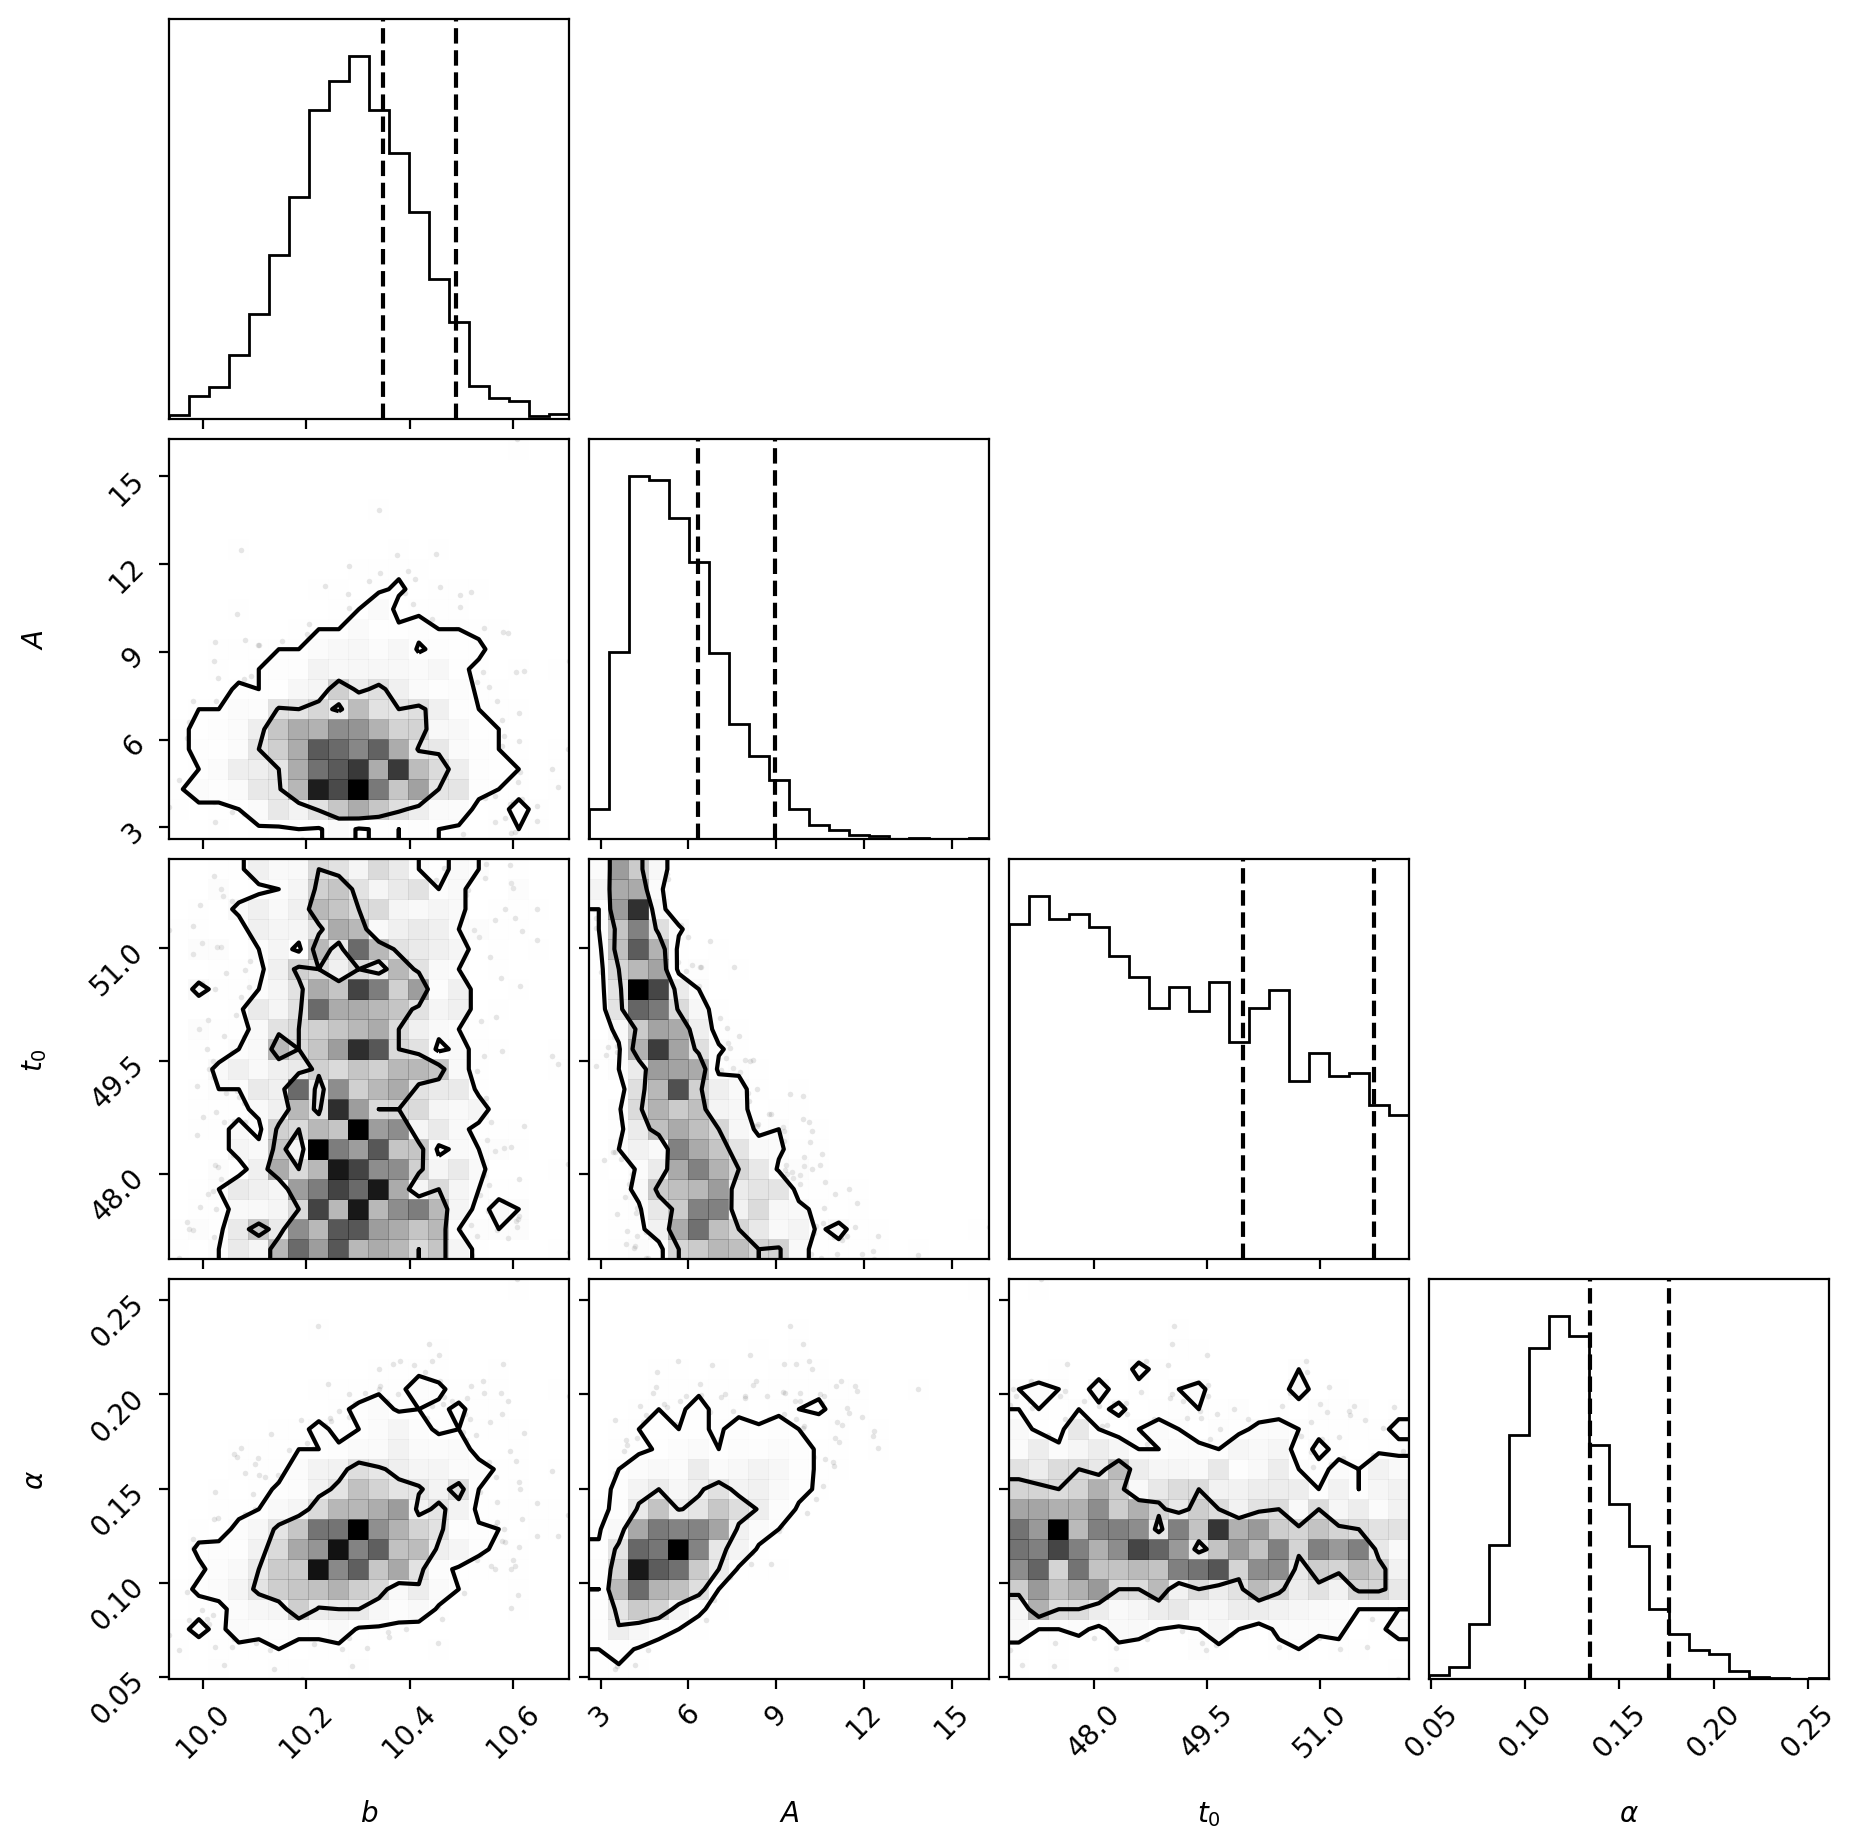

In [146]:
fig = corner.corner(flat_samples, labels=labels, levels=[0.68,0.95], quantiles=[0.68, 0.95]);

---

### Extract 100 random samples from the chain for parameter estimation:

In [155]:
rng = np.random.default_rng()
rand_samples = rng.choice(flat_samples, size=100)

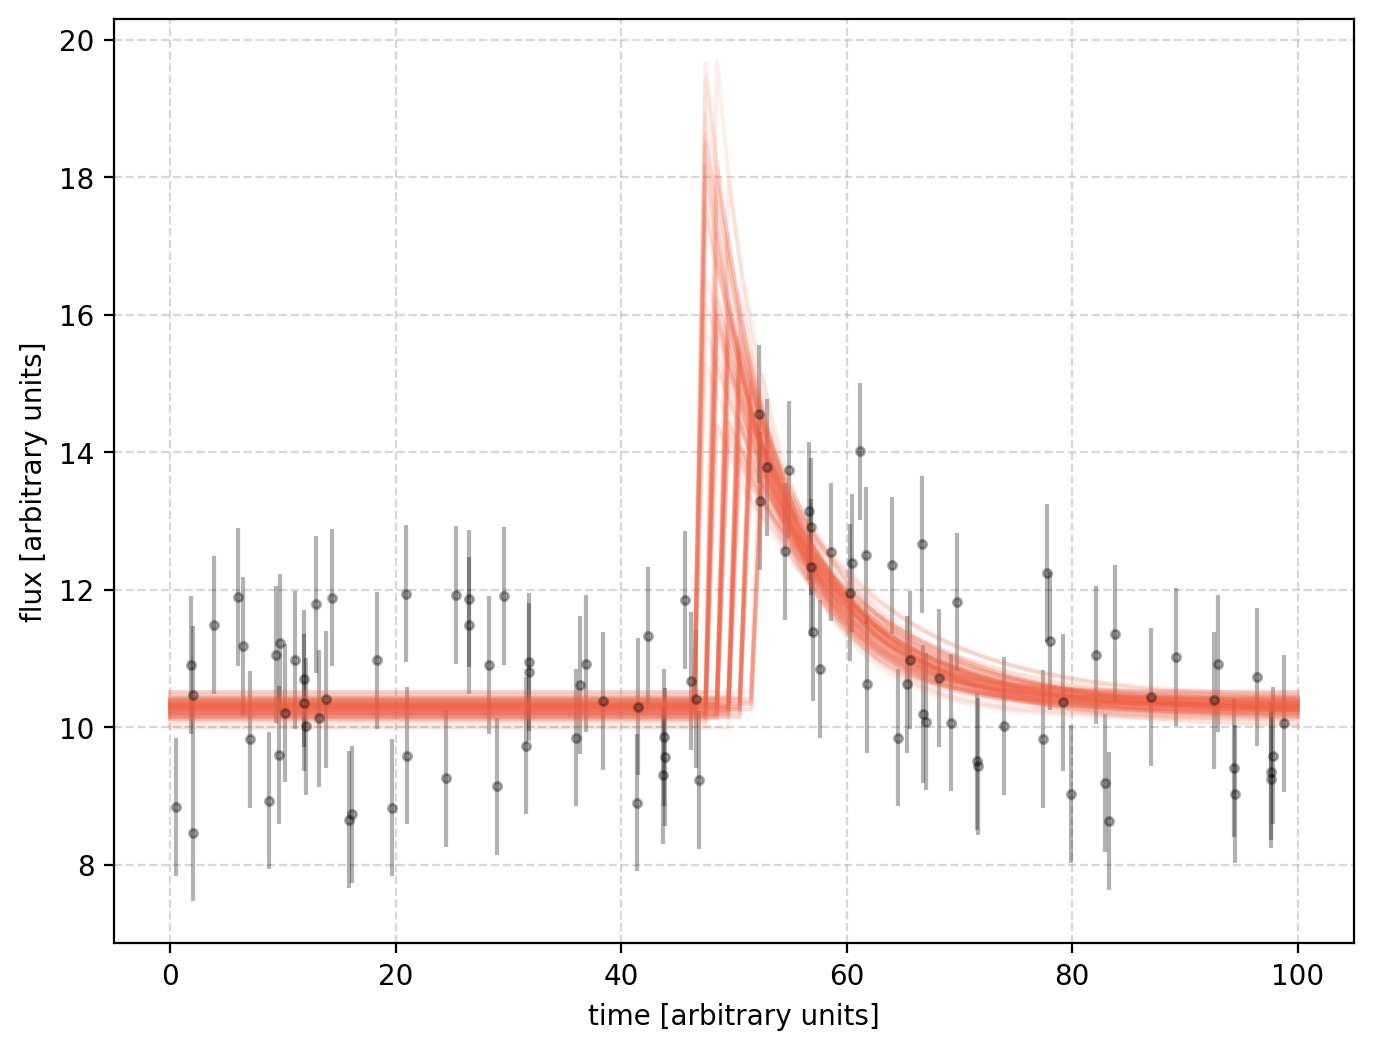

In [162]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
xgrid = np.linspace(0, 100, 100)

ax.set_xlabel('time [arbitrary units]')
ax.set_ylabel('flux [arbitrary units]')
ax.errorbar(time, flux, yerr=errors, fmt=".", c='black', alpha=0.3)

for sample in rand_samples:
    ax.plot(xgrid, burst_f(xgrid, sample), color=c[3], alpha=0.1)
ax.grid(True, ls='--', alpha=0.5)

In [236]:
medians = median_sigmaG(rand_samples, axis=0)
medians = [val for val in medians]

print(medians[0]) #The medians for the parameters

upper_bounds = np.percentile(rand_samples[:, :], 95, axis=0) - medians[0]
lower_bounds = medians[0] - np.percentile(rand_samples[:, :], 5, axis=0)

[10.28374015  5.42774748 49.11392643  0.12246503]
[0.15922627 3.13689232 2.5904969  0.04320657]


In [245]:
for count, value in enumerate(labels):
    print(r"Best estimate of %s"%value[1:-1], "is: ", round(medians[0][count], 2), "+", round(upper_bounds[count], 2), "-", 
         round(lower_bounds[count], 2))

Best estimate of b is:  10.28 + 0.16 - 0.16
Best estimate of A is:  5.43 + 3.14 - 1.65
Best estimate of t_0 is:  49.11 + 2.59 - 1.98
Best estimate of \alpha is:  0.12 + 0.04 - 0.04
